In [8]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import matplotlib.dates 
import datetime
import time
import sklearn
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.grid_search import ParameterGrid
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
import xgboost as xgb
import rms_data
import rms_eval
import importlib
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
%matplotlib inline
import csv
import sys

In [2]:
#For python 2
reload(rms_eval)
reload(rms_data)

<module 'rms_data' from 'rms_data.pyc'>

In [3]:
def load_data():
    
    #Read in files
    print "Reading in all three files"
    train = pd.read_csv('train.csv', low_memory=False)
    store = pd.read_csv('store.csv', low_memory=False)
    test = pd.read_csv('test.csv', low_memory=False)
    
    #Select only stores that are open and ?have sales more than 0
    opened = train.Open==1
    salesGT0 = train.Sales > 0
    train = train[opened & salesGT0]
    
    #Join train and store data
    train_store = pd.merge(train, store, on="Store")
    test_store = pd.merge(test, store, on="Store")
    
    #Feature engineering
    train_proc = rms_data.data_prep_v1(train_store)
    test_proc = rms_data.data_prep_v1(test_store, False)
    
    #Store sales in another variable and drop it
    tmp_y = train_proc.Sales
    train_proc.drop('Sales', axis=1, inplace=True)
    train_x = train_proc
    train_y = tmp_y

    #Fill in missing values with -1
    train_x.fillna(-1, inplace=True) #because random forests cannot handle np.nan
    test.fillna(-1, inplace=True)
    
    return train_x, train_y, test_proc

In [4]:
def score(params):
    print "Training with params : "
    print params

    N_boost_round=[]
    Score=[]
    
    kf = KFold(y_train.shape[0], n_folds=5, shuffle=True, random_state=23497832)

    for train, test in kf:
    
        X_Train, X_Test, y_Train, y_Test = X_train[train], X_train[test], y_train[train], y_train[test]

        dtrain = xgb.DMatrix(X_Train, label=y_Train, missing=-1)
        dtest = xgb.DMatrix(X_Test, label=y_Test, missing=-1)
        dvalid = xgb.DMatrix(X_test, label=y_test, missing=-1)
        watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
        
        model = xgb.train(params, dtrain, num_boost_round=1500, evals=watchlist, early_stopping_rounds=10,
                          maximize=False, feval=rms_eval.rmspe_sqrt_xgb, verbose_eval=True)
        
        #Get predictions
        predictions = model.predict(dtest, ntree_limit=model.best_iteration+1)
        N = model.best_iteration
        N_boost_round.append(N)
        print 'N:', str(N)

        #Get error
        score = rms_eval.rmspe_sqrt_skl(y_Test, predictions)
        Score.append(score)
        
        print("Best train error:" + str(model.best_score) + " Best iteration:" + 
              str(model.best_iteration) + " Test error:" + str(score))

    Average_best_num_boost_round = np.average(N_boost_round)
    Average_best_score = np.average(Score)

    writer.writerow([Average_best_score] + [np.std(Score)] + list(params.values()))
    o_f.flush()

    print "\tAverage of best iteration {0}\n".format(Average_best_num_boost_round)
    print "\tAverage best score {0}\n\n".format(Average_best_score)
    return {'loss': Average_best_score, 'status': STATUS_OK}

In [5]:
def optimize(trials):
    space = {
             'booster': 'gbtree', #gblinear
             'objective': "reg:linear",
        
             #Control complexity of model
             #'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'eta': hp.quniform('eta', 0.01, 0.05, 0.01),

             #'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             'max_depth': hp.choice('max_depth', np.arange(1, 30, dtype=int)),

             #'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),

             #'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.1, 1, 0.1),

             #Improve noise robustness
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             #'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 0.75, 0.05),
        
             'nthread' : 1,
             'seed': 2457238,
             'silent': 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=3)

    print "best parameters ", best

In [ ]:
train_x, train_y, test_x = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    train_x.values, train_y.values, test_size=0.15, random_state=1234)

output_file = 'xgb_hyperopt_log.csv'
headers = [ 'rmspe_mean', 'rmspe_std', 'colsample_bytree', 'silent', 'nthread', 
           'min_child_weight', 'subsample', 'eta', 'objective', 'seed',
           'max_depth', 'gamma', 'booster']
o_f = open( output_file, 'wb' )
writer = csv.writer( o_f )
writer.writerow( headers )

np.random.seed(23748)

#Trials object where the history of search will be stored
trials = Trials()

optimize(trials)

Reading in all three files
Training with params : 
{'colsample_bytree': 0.4, 'silent': 1, 'nthread': 1, 'min_child_weight': 5.0, 'subsample': 0.8, 'eta': 0.01, 'objective': 'reg:linear', 'seed': 2457238, 'max_depth': 11, 'gamma': 0.5, 'booster': 'gbtree'}
[0]	train-rmse:82.116	eval-rmse:82.0436	train-rmspe:0.999713	eval-rmspe:0.999712
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 10 rounds.
[1]	train-rmse:81.3215	eval-rmse:81.2491	train-rmspe:0.99926	eval-rmspe:0.999258
[2]	train-rmse:80.5397	eval-rmse:80.4672	train-rmspe:0.998594	eval-rmspe:0.998591
[3]	train-rmse:79.765	eval-rmse:79.6928	train-rmspe:0.997729	eval-rmspe:0.997724
[4]	train-rmse:78.9907	eval-rmse:78.9185	train-rmspe:0.996692	eval-rmspe:0.996685
[5]	train-rmse:78.2278	eval-rmse:78.1563	train-rmspe:0.995461	eval-rmspe:0.995452
[6]	train-rmse:77.4729	eval-rmse:77.4021	train-rmspe:0.99405	eval-rmspe:0.994041
[7]	train-rmse:76.732	eval-rm

In [7]:
cv_results = pd.read_csv('xgb_hyperopt_log_4.csv', low_memory=False)
cv_results.head()

,rmspe_mean,rmspe_std,colsample_bytree,silent,nthread,min_child_weight,subsample,eta,objective,seed,max_depth,gamma,booster
0,0.162087,0.097645,0.55,1,1,5,0.95,0.050,reg:linear,2457238,13,0.50,gbtree
1,0.162192,0.096424,0.50,1,1,5,0.95,0.050,reg:linear,2457238,13,0.55,gbtree
2,0.162761,0.097257,0.50,1,1,4,0.90,0.075,reg:linear,2457238,13,0.55,gbtree
3,0.162829,0.095085,0.55,1,1,5,0.55,0.075,reg:linear,2457238,13,0.65,gbtree
4,0.163303,0.089460,0.65,1,1,3,0.95,0.250,reg:linear,2457238,13,0.50,gbtree


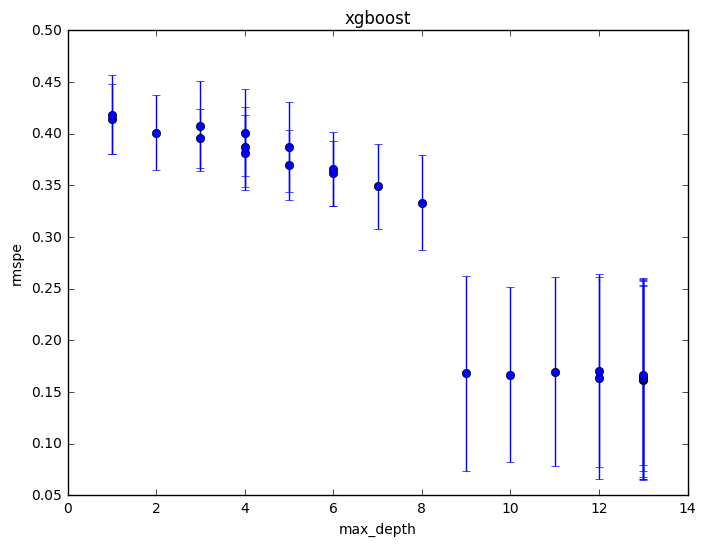

In [18]:
plt.figure(figsize=(8,6))
plt.errorbar(cv_results['max_depth'], cv_results['rmspe_mean'], cv_results['rmspe_std'], linestyle='None', marker='o')
plt.title('xgboost')
plt.xlabel('max_depth')
plt.ylabel('rmspe')
plt.show()

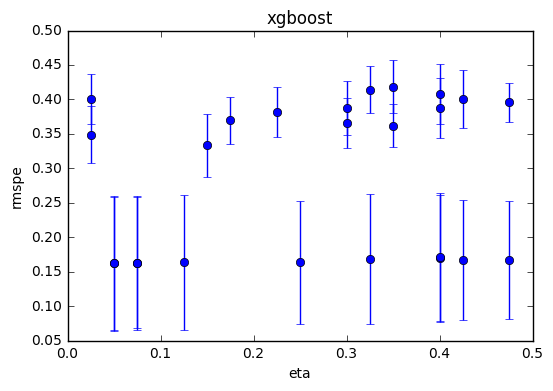

In [15]:
plt.errorbar(cv_results['eta'], cv_results['rmspe_mean'], cv_results['rmspe_std'], linestyle='None', marker='o')
plt.title('xgboost')
plt.xlabel('eta')
plt.ylabel('rmspe')
plt.show()